# 1.IMPORTING NECESSARY LIBRARIES

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2.DATA LOADING

In [ ]:
transform = transforms.Compose([transforms.Pad(4),transforms.RandomHorizontalFlip(),transforms.RandomCrop(32),transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=True, transform=transform,download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=False, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [ ]:
train_dataset, val_dataset= random_split(train_dataset,(45000,5000))

In [ ]:
train_loader = DataLoader(dataset=train_dataset,batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=100, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset,batch_size=100, shuffle=False)

# 3. BUILDING RESNET ARCHITECTURE

#3.1 RESIDUAL BLOCK

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(input_channels, output_channels, stride)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(output_channels, output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample:
            residual = self.downsample(x)
        output += residual
        output = self.relu(output)
        return output

#3.2 CREATING AND ADDING THE LAYERS

In [ ]:
class Resnet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(Resnet, self).__init__()
        self.input_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, output_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.input_channels != output_channels):
           downsample = nn.Sequential(conv3x3(self.input_channels, output_channels, stride=stride),nn.BatchNorm2d(output_channels))
        layers = []
        layers.append(block(self.input_channels, output_channels, stride, downsample))
        self.input_channels = output_channels
        for i in range(1, blocks):
            layers.append(block(output_channels, output_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv(x)
        output = self.bn(output)
        output = self.relu(output)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

#4.DEFINING HYPERPARAMS

In [ ]:
num_epochs = 20
learning_rate = 0.001

model = Resnet(ResidualBlock, [2, 2, 2]).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

#5.TRAINING MODEL

In [ ]:
train_costs,val_costs,train_acc,val_acc=[],[],[],[]

labels_train=[]

for epoch in range(num_epochs):

    train_correct=0
    train_running_loss=0
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)
     
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted==labels).float().sum().item()
        train_running_loss +=(loss.data.item()*images.shape[0])
 
    # training loss and accuracy calculation
    train_epoch_loss= train_running_loss/len(train_dataset)
    train_costs.append(train_epoch_loss)
    train_accuracy=train_correct/len(train_dataset)
    train_acc.append(train_accuracy)

    val_correct=0
    val_running_loss=0
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
          images = images.to(device)
          labels = labels.to(device)

        # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)


          _, predicted = torch.max(outputs.data, 1)
          val_correct += (predicted==labels).float().sum().item()
          val_running_loss +=(loss.data.item()*images.shape[0])

   
        # validation loss and accuracy calculation
        val_epoch_loss= val_running_loss/len(val_dataset)
        val_costs.append(val_epoch_loss)
        val_accuracy=val_correct/len(val_dataset)
        val_acc.append(val_accuracy)




    
    print ("Epoch [{}/{}],  train_epoch_Loss: {:.4f}, val_epoch_loss: {:.4f}, train_accuracy: {:.4f}, val_accuracy: {:.4f}".format(epoch+1, num_epochs, train_epoch_loss,val_epoch_loss,train_accuracy,val_accuracy ))
 

Epoch [1/20],  train_epoch_Loss: 1.4598, val_epoch_loss: 1.2919, train_accuracy: 0.4628, val_accuracy: 0.5216
Epoch [2/20],  train_epoch_Loss: 1.9418, val_epoch_loss: 1.7346, train_accuracy: 0.2721, val_accuracy: 0.3596
Epoch [3/20],  train_epoch_Loss: 1.5320, val_epoch_loss: 1.3740, train_accuracy: 0.4316, val_accuracy: 0.4836
Epoch [4/20],  train_epoch_Loss: 1.2984, val_epoch_loss: 1.2090, train_accuracy: 0.5231, val_accuracy: 0.5676
Epoch [5/20],  train_epoch_Loss: 1.1569, val_epoch_loss: 1.0823, train_accuracy: 0.5773, val_accuracy: 0.6114
Epoch [6/20],  train_epoch_Loss: 1.0551, val_epoch_loss: 1.0297, train_accuracy: 0.6178, val_accuracy: 0.6266
Epoch [7/20],  train_epoch_Loss: 0.9899, val_epoch_loss: 0.9657, train_accuracy: 0.6418, val_accuracy: 0.6590
Epoch [8/20],  train_epoch_Loss: 0.9330, val_epoch_loss: 0.9047, train_accuracy: 0.6644, val_accuracy: 0.6746
Epoch [9/20],  train_epoch_Loss: 0.8731, val_epoch_loss: 0.8778, train_accuracy: 0.6875, val_accuracy: 0.6898
Epoch [10/

#6.TESTING MODEL

In [ ]:
model.eval()
y_true,y_pred=[],[]
with torch.no_grad():

    test_correct = 0
    test_total = 0

    for images, labels in test_loader:
        y_true.extend(labels.numpy())
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    print('Accuracy of this model on the test images: {} %'.format(100 * test_correct / test_total))

Accuracy of this model on the test images: 79.95 %


#7.GRAPHICAL INSIGHTS

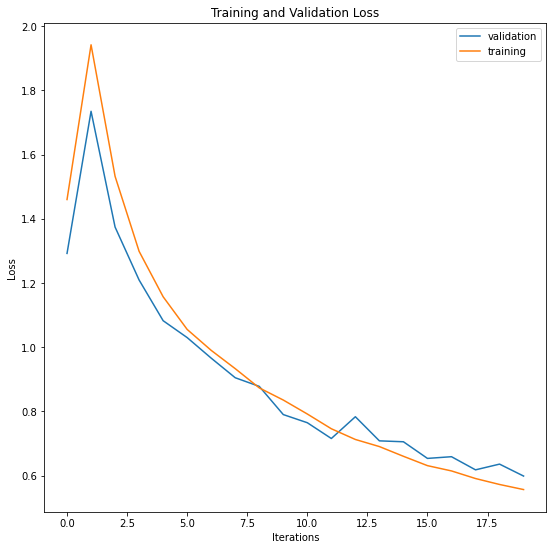

In [ ]:
plt.figure(figsize=(9,9))

plt.title("Training and Validation Loss")
plt.plot(val_costs,label="validation")
plt.plot(train_costs,label="training")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

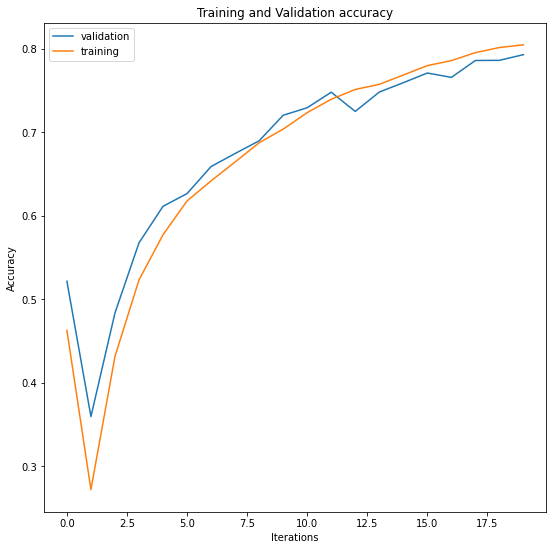

In [ ]:
plt.figure(figsize=(9,9))

plt.title("Training and Validation accuracy")

plt.plot(val_acc,label="validation")
plt.plot(train_acc,label="training")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix,roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

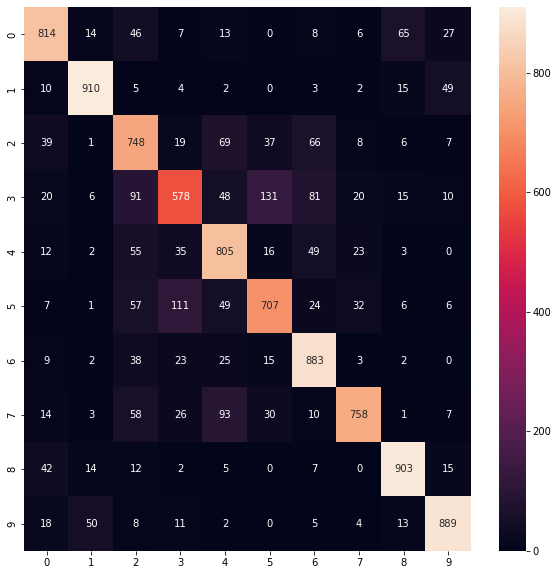

In [ ]:
plt.figure(figsize=(10,10))
cm=confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt='d')